## Imports

In [1]:
import os
import glob
import numpy as np
import re
import warnings
import astroalign as aa

import matplotlib.pyplot as plt
from datetime import datetime
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from astropy.time import Time
from astropy.table import Table, Column

%matplotlib inline

In [2]:
# Current working directory
os.getcwd()

'/home/mb0078/Sci/_obs/reduction'

# Setup

Set up data paths, output paths etc. These are the user-configurable parameters for data reduction.


In [5]:
raw_sci_path = ""
bias_path = os.path.join(raw_sci_path, "calib")
dark_path = os.path.join(raw_sci_path, "calib")
flat_path = os.path.join(raw_sci_path, "calib")

master_path = os.path.join(raw_sci_path, "masters")
calibrated_path = os.path.join(raw_sci_path, "calibrated")
stacked_path = os.path.join(raw_sci_path, "stacked")

do_image_stacking = True
stack_target_names = None    # None to stack everything; iterable of strings with names to only stack certain targets

use_ready_masters = {
    "bias": False,
    "dark": False,
    "flat": False
    }

# Set these to None if the data folder only contains one fits file category

science_regex = None

dark_regex = r"^dark"
bias_regex = r"^bias_BIAS"
flat_regex = r"GoT1_FLAT"


# Misc config

fits_shape = 3194, 4788  # GoChile binning 2 shape
observer_name = "Mateusz Bronikowski"  # Goes into FITS headers. Leave None to leave original observer in headers

new_dark_scale = 60.  # Exposure time to which to scale any new master darks. Existing master darks will be used based on header data

masters_dtype = np.float32  # For newly created master bias and dark, not reused masters. Master flats will always be float32.
sci_frame_dtype = np.float32  # dtype to save scientific frames in
stacked_dtype = np.float32

fits_extension = ".FIT"  # For finding FITS files created by the telescope, I can't be bothered making it automatic. Sorry!
fix_lowercase_gaia = True  # Replace lowercase "gaia" in Gaia Alerts target names with uppercase in headers.


## Helper functions

Here we define some useful functions and hidden parameters, create missing folders etc. The user doesn't need to interact with this section.


In [9]:
def list_fits_files(directory, regex_pattern):
    # Create the full path pattern to match all .fits files
    pattern = os.path.join(directory, '*' + fits_extension)
    # List all .fits files in the directory
    all_fits_files = glob.glob(pattern)

    if regex_pattern is None:
        return all_fits_files
    
    # Compile the regex pattern
    regex = re.compile(regex_pattern)
    # Filter files that match the regex pattern
    matched_files = [f for f in all_fits_files if regex.search(os.path.basename(f))]
    
    return matched_files


def curr_iso_time_str():
    return datetime.now().isoformat()[:19]    # Cut at seconds. GoChile won't require a higher precision anyway


def jd_to_iso(jd):
    time_jd = Time(jd, format='jd')
    iso_jd = time_jd.to_value('iso', subfmt='date_hms')
    return iso_jd[:19]


def mjd_to_iso(mjd):
    time_mjd = Time(mjd, format='mjd')
    iso_mjd = time_mjd.to_value('iso', subfmt='date_hms')
    return iso_mjd[:19]


def preview_image(image_array, cmap='gray', sigma_low=3, sigma_high=10, title="Image preview"):
    # Compute the mean and standard deviation of the image
    mean = np.mean(image_array)
    std = np.std(image_array)
    
    # Set the lower and upper bounds based on sigma
    lower_bound = mean - sigma_low * std
    upper_bound = mean + sigma_high * std
    
    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    plt.imshow(image_array, cmap=cmap, vmin=lower_bound, vmax=upper_bound, aspect='equal')

    plt.colorbar(label='Pixel value')
    ax.set_title(title)

    plt.show()


# This is needed to fix FITS headers, otherwise the data type won't match the header.
dtype_to_bitpix = {
    np.int16: 16,
    np.int32: 32,
    np.float32: -32,
    np.float64: -64,
    np.uint8: 8,
    np.int8: 8,
    np.uint16: 16,
    np.uint32: 32,
}

for path in (master_path, calibrated_path):
    if not os.path.exists(path):
        os.mkdir(path)
if not os.path.exists(stacked_path) and do_image_stacking:
    os.mkdir(stacked_path)


# Load and calibrate

Load up the scientific and calibration frames, then calibrate the frames.

## Bias

Minimum value: 477.0; maximum value: 536.0


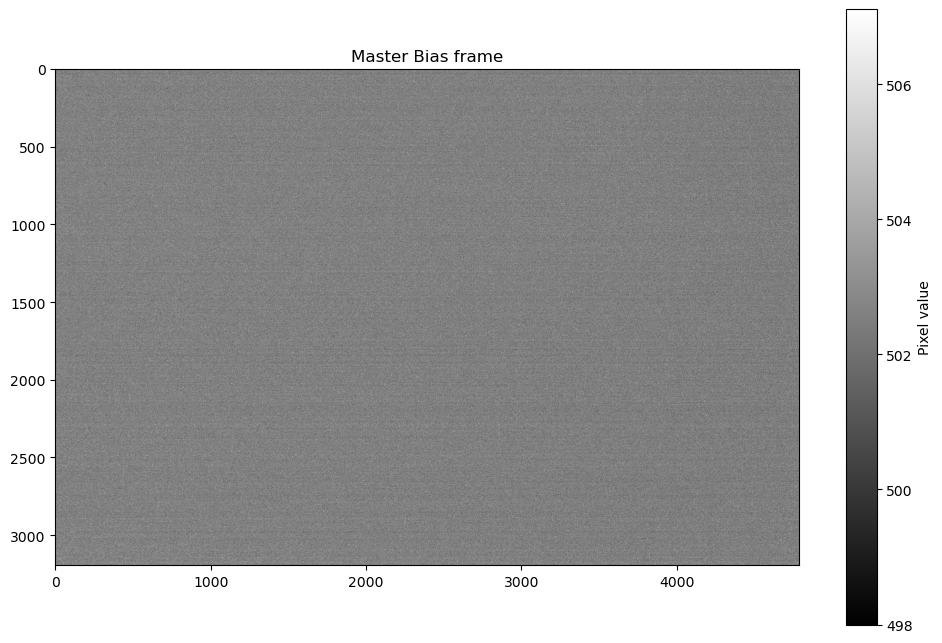

In [20]:
def create_master_bias():
    bias_fits = list_fits_files(bias_path, bias_regex)

    all_data = np.empty((len(bias_fits), fits_shape[0], fits_shape[1]), dtype=np.float64)
    for idx, filepath in enumerate(bias_fits):
        # TODO: Add sensor temperature check and warning
        all_data[idx, :, :] = fits.getdata(filepath)
        

    master_data, _, _ = sigma_clipped_stats(all_data, axis=0)  # 3-sigma clipped average
    np.clip(master_data, 0, 65535, out=master_data)
    master_data = master_data.astype(masters_dtype)
    hdr = fits.getheader(bias_fits[0]).copy()    
    if observer_name is not None:
        hdr['OBSERVER'] = observer_name    
    hdr["NFRAMES"] = len(bias_fits)
    hdr['BITPIX'] = dtype_to_bitpix[masters_dtype]
    hdr["NFRAMES"] = len(bias_fits)
    hdr['COMBTYPE'] = 'SIGCLIP'
    hdr['SIGCLIP'] = '3'
    hdr.remove('BSCALE', ignore_missing=True)
    hdr.remove('BZERO', ignore_missing=True)
    hdr.add_history('3-sigma clipped mean combined')
    hdu = fits.PrimaryHDU(master_data)
    hdu.header = hdr
    output_path = os.path.join(master_path, "Master_Bias" + fits_extension)
    hdu.writeto(output_path, overwrite=True)
    return master_data


if use_ready_masters['bias']:
    pass  # TODO: load master bias
else:
    master_bias = create_master_bias()

print(f"Minimum value: {np.min(master_bias)}; maximum value: {np.max(master_bias)}")
preview_image(master_bias, cmap='gray', sigma_low=3, sigma_high=3, title="Master Bias frame")


# Dark

Minimum value: 0.0; maximum value: 16275.599609375


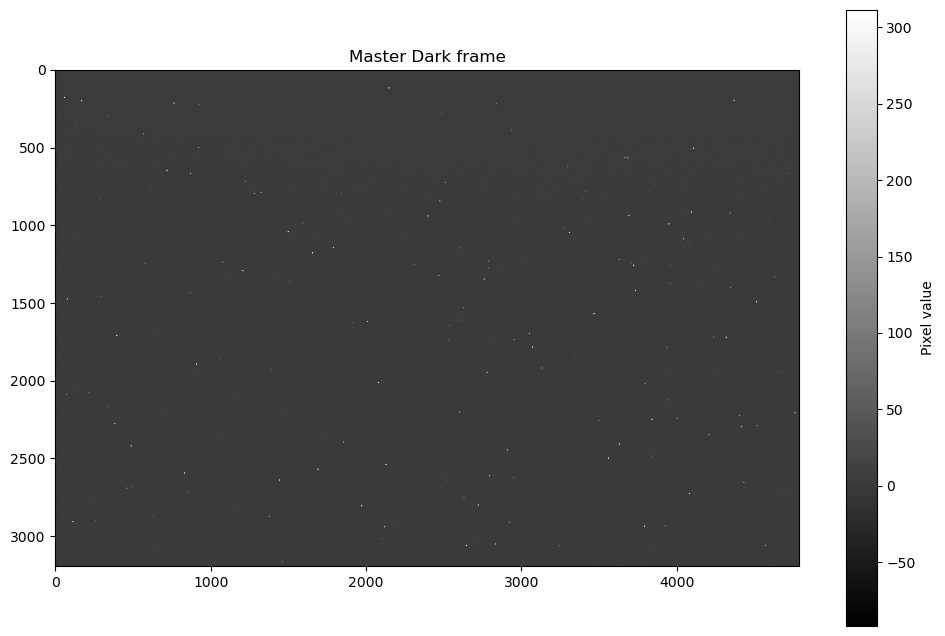

In [21]:
def create_master_dark():
    dark_fits = list_fits_files(dark_path, dark_regex)

    all_data = np.empty((len(dark_fits), fits_shape[0], fits_shape[1]), dtype=np.float64)
    exptimes = np.empty(len(dark_fits))
    for idx, filepath in enumerate(dark_fits):
        # TODO: Add sensor temperature check and warning
        all_data[idx, :, :] = fits.getdata(filepath)
        exptimes[idx] = float(fits.getheader(dark_fits[idx])["EXPTIME"])
        all_data[idx, :, :] -= master_bias
        all_data[idx, :, :] *= new_dark_scale / exptimes[idx]
    
    master_data, _, _ = sigma_clipped_stats(all_data, axis=0)  # 3-sigma clipped average
    np.clip(master_data, 0, 65535, out=master_data)
    master_data = master_data.astype(masters_dtype)
    hdr = fits.getheader(dark_fits[0]).copy()
    hdr['BITPIX'] = dtype_to_bitpix[masters_dtype]
    if observer_name is not None:
        hdr['OBSERVER'] = observer_name    
    hdr["NFRAMES"] = len(dark_fits)
    hdr['COMBTYPE'] = 'SIGCLIP'
    hdr['SIGCLIP'] = '3'
    hdr.remove('BSCALE', ignore_missing=True)
    hdr.remove('BZERO', ignore_missing=True)
    hdr.add_history('Bias subtraction performed')
    hdr.add_history('3-sigma clipped mean combined')
    hdr['EXPTIME'] = str(round(new_dark_scale, 3))
    hdr['EXPOSURE'] = str(round(new_dark_scale, 3))
    hdu = fits.PrimaryHDU(master_data)
    hdu.header = hdr
    output_path = os.path.join(master_path, "Master_Dark" + fits_extension)
    hdu.writeto(output_path, overwrite=True)
    return master_data


if use_ready_masters['dark']:
    pass  # TODO: load master dark into master_dark, dark_scale
else:
    master_dark, dark_scale = create_master_dark(), new_dark_scale

print(f"Minimum value: {np.min(master_dark)}; maximum value: {np.max(master_dark)}")
preview_image(master_dark, cmap='gray', sigma_low=3, sigma_high=10, title="Master Dark frame")
    

# Flat

Flat filter G / DARK. Minimum value: 0.5327678322792053; maximum value: 1.3631584644317627


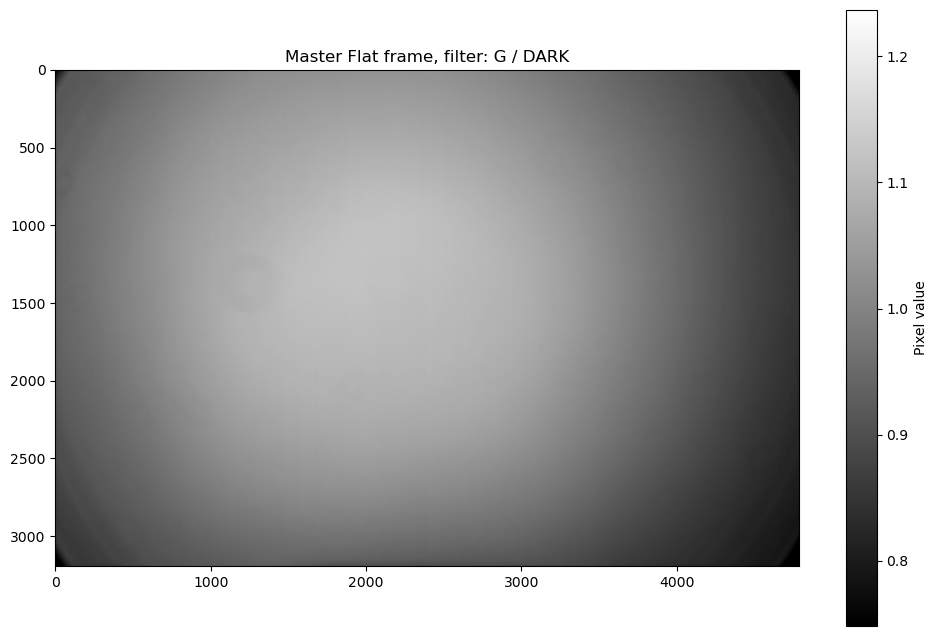

Flat filter B. Minimum value: 0.4650952219963074; maximum value: 1.3166426420211792


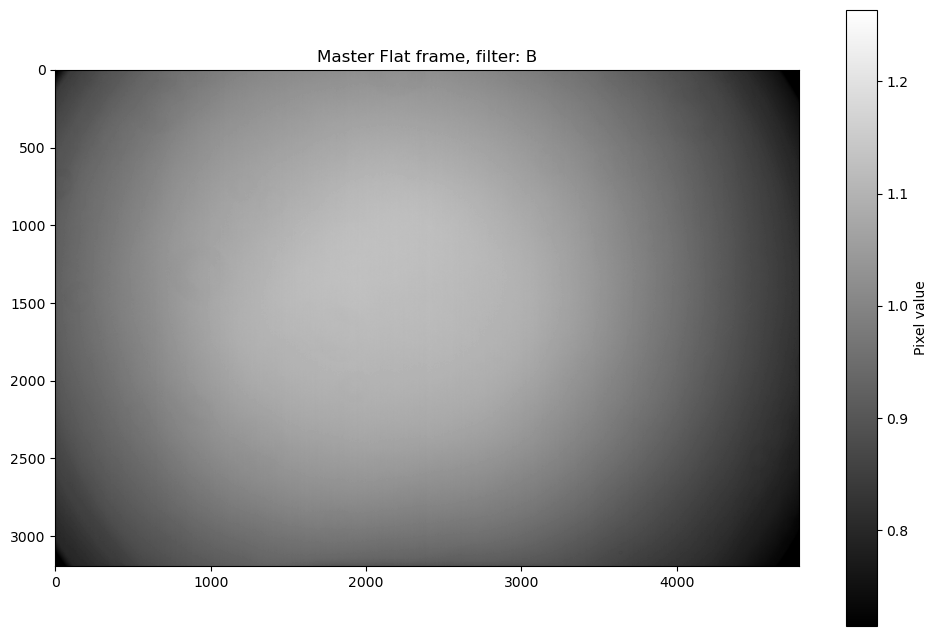

Flat filter R / HaO3. Minimum value: 0.4457615613937378; maximum value: 1.295284628868103


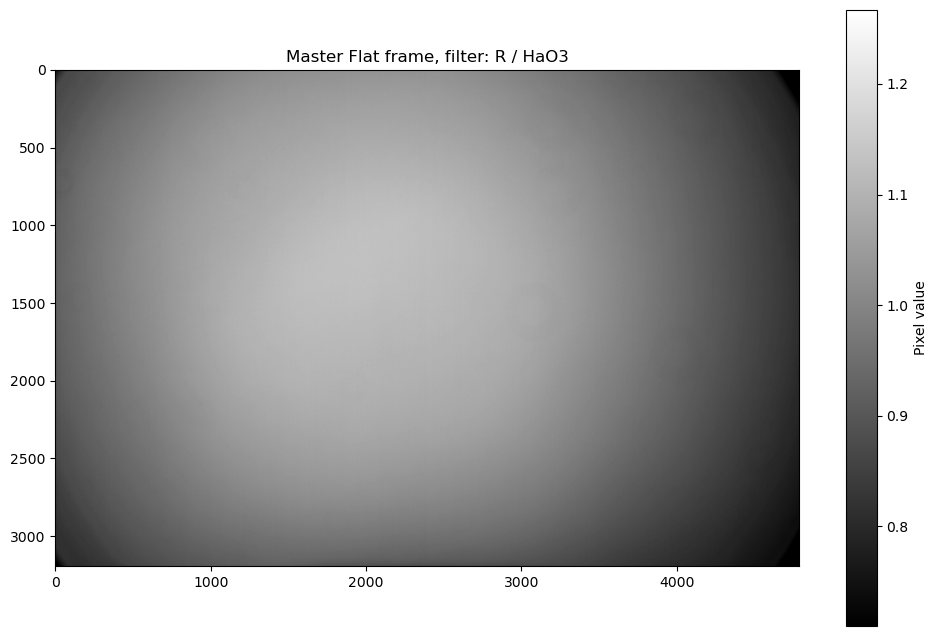

In [24]:
def create_master_flat():
    flat_fits = list_fits_files(flat_path, flat_regex)
    filters_files = {}
    for filename in flat_fits:
        filter_name = fits.getheader(filename).copy()['FILTER']
        try:
            filters_files[filter_name].append(filename)
        except KeyError:
            filters_files[filter_name] = []

    all_data = {}
    for filter_name in filters_files.keys():
        flat_data = np.empty((len(filters_files[filter_name]), fits_shape[0], fits_shape[1]), dtype=np.float32)
        for idx, filename in enumerate(filters_files[filter_name]):
            flat_data[idx, :, :] = fits.getdata(filename)  # Load frames
            exptime = float(fits.getheader(filename)["EXPTIME"])  # Get exposure time for dark correction
            flat_data[idx, :, :] -= master_bias  # Bias correction
            flat_data[idx, :, :] -= master_dark * exptime / dark_scale  # Dark correction
            flat_data[idx, :, :] /= np.median(flat_data[idx, :, :])  # normalize
        all_data[filter_name], _, _ = sigma_clipped_stats(flat_data, axis=0)
        np.clip(all_data[filter_name], 0, 65535, out=all_data[filter_name])
        all_data[filter_name] = all_data[filter_name].astype(masters_dtype)
        hdr = fits.getheader(filters_files[filter_name][0]).copy()
        hdr['BITPIX'] = dtype_to_bitpix[masters_dtype]
        if observer_name is not None:
            hdr['OBSERVER'] = observer_name
        hdr["NFRAMES"] = len(filters_files[filter_name])
        hdr['COMBTYPE'] = 'SIGCLIP'
        hdr['SIGCLIP'] = '3'
        hdr.remove('BSCALE', ignore_missing=True)
        hdr.remove('BZERO', ignore_missing=True)
        hdr.add_history('Bias subtraction performed')
        hdr.add_history('Dark subtraction performed')
        hdr.add_history('3-sigma clipped mean combined')
        hdu = fits.PrimaryHDU(all_data[filter_name])
        hdu.header = hdr
        safe_filter_name = filter_name.replace('/', '').replace(' ', '_')
        output_path = os.path.join(master_path, "Master_Flat_" + safe_filter_name + fits_extension)
        hdu.writeto(output_path, overwrite=True)

    return all_data


if use_ready_masters['flat']:
    pass  # TODO: load flats
else:
    master_flat = create_master_flat()

for flat_filter in master_flat.keys():
    print(f"Flat filter {flat_filter}. Minimum value: {np.min(master_flat[flat_filter])}; maximum value: {np.max(master_flat[flat_filter])}")
    preview_image(master_flat[flat_filter], cmap='gray', sigma_low=3, sigma_high=3, title=f"Master Flat frame, filter: {flat_filter}")


# Science frame calibration

In [7]:
def calib_science_frames():
    science_fits_paths = list_fits_files(raw_sci_path, science_regex)

    for fits_path in science_fits_paths:
        sci_hdr = fits.getheader(fits_path)
        exptime = float(sci_hdr['EXPTIME'])
        filter_name = sci_hdr['FILTER']
        if filter_name not in master_flat.keys():
            warnings.warn(f'FITS file {fits_path} uses filter "{filter_name}", but no flat is available for that filter. Skipping frame.')
            continue

        frame = fits.getdata(fits_path).astype(np.float32)

        frame -= master_bias
        frame -= master_dark * exptime / dark_scale
        frame /= master_flat[filter_name]
        np.clip(frame, 0, None, out=frame)
        frame = frame.astype(sci_frame_dtype)

        if fix_lowercase_gaia:
            sci_hdr['OBJECT'] = sci_hdr['OBJECT'].replace("gaia", "Gaia")
        
        sci_hdr['BITPIX'] = dtype_to_bitpix[sci_frame_dtype]
        if observer_name is not None:
            sci_hdr['OBSERVER'] = observer_name
        sci_hdr['PROCTIME'] = curr_iso_time_str()
        sci_hdr.add_history('Bias subtraction performed')
        sci_hdr.add_history('Dark subtraction performed')
        sci_hdr.add_history('Flat correction applied')
        sci_hdr.remove('BSCALE', ignore_missing=True)
        sci_hdr.remove('BZERO', ignore_missing=True)
        hdu = fits.PrimaryHDU(frame)
        hdu.header = sci_hdr

        filename = sci_hdr['OBJECT'] + '_' + sci_hdr['FILTER'] + '_' + sci_hdr['DATE-OBS'] + fits_extension
        filename = filename.replace("/", "_")
        filename = filename.replace(" ", "")
        hdu.writeto(os.path.join(calibrated_path, filename), overwrite=True)


    # Load frame
    # Load up header
    # Pick filter
    # Subtract bias
    # Scale and subtract dark
    # Divide by flat
    # Save the new file in calibrated. Standardize filename

# for frame in science frames:
    # calib_science_frame()
calib_science_frames()


# Stacking

Stacked 15 frames, target AT2024mxf, filter G / DARK. Total exptime: 2700.0 s, 15 frames


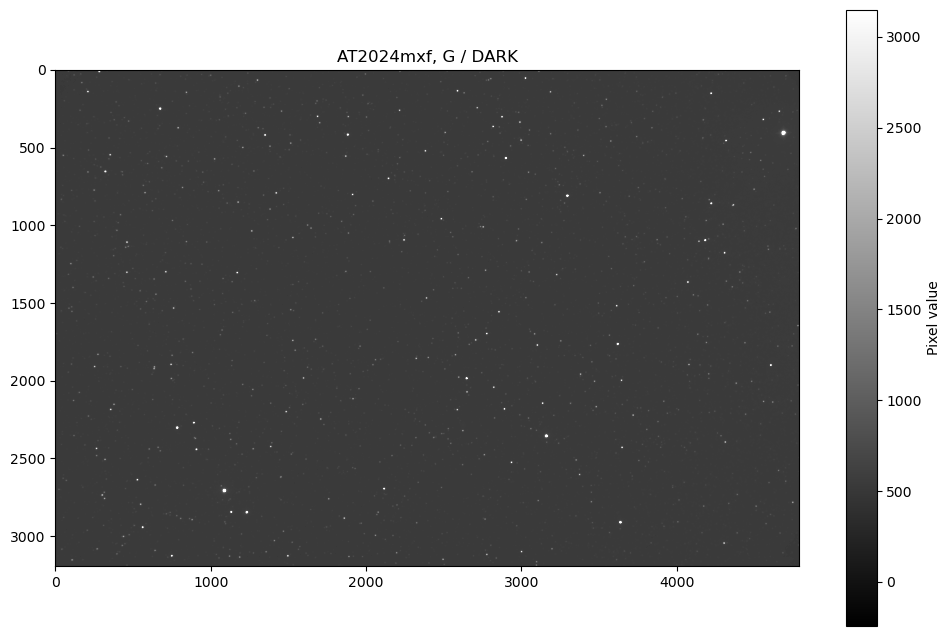

Stacked 15 frames, target AT2024mxf, filter R / HaO3. Total exptime: 2700.0 s, 15 frames


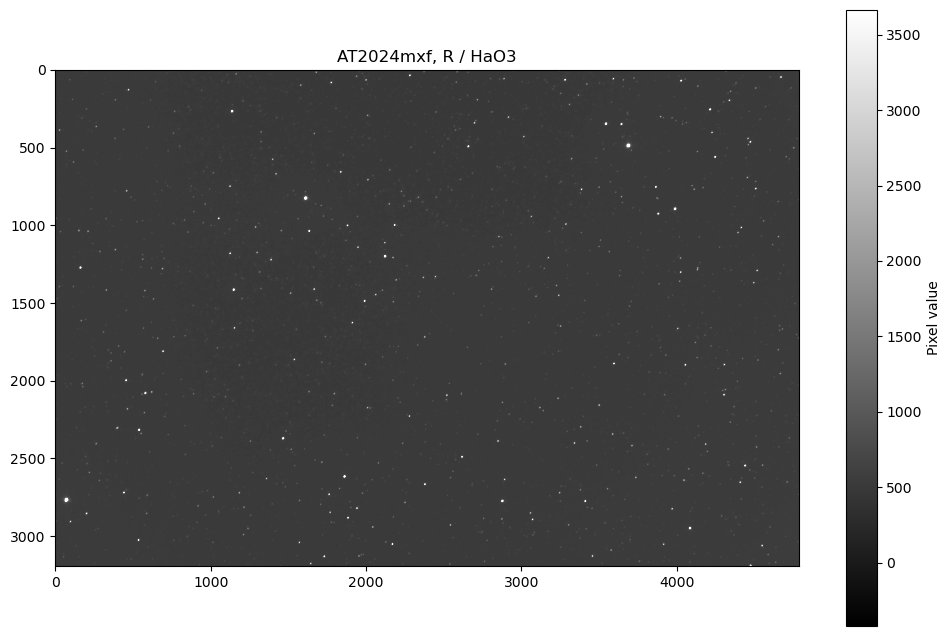

Stacked 10 frames, target Gaia18bwz, filter G / DARK. Total exptime: 900.0 s, 10 frames


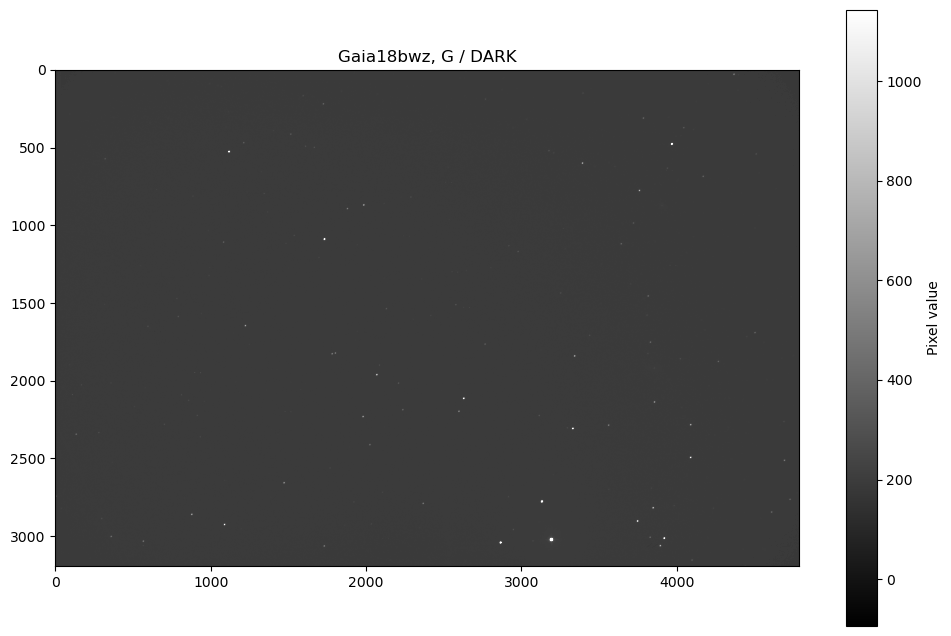

Stacked 10 frames, target Gaia18bwz, filter R / HaO3. Total exptime: 900.0 s, 10 frames


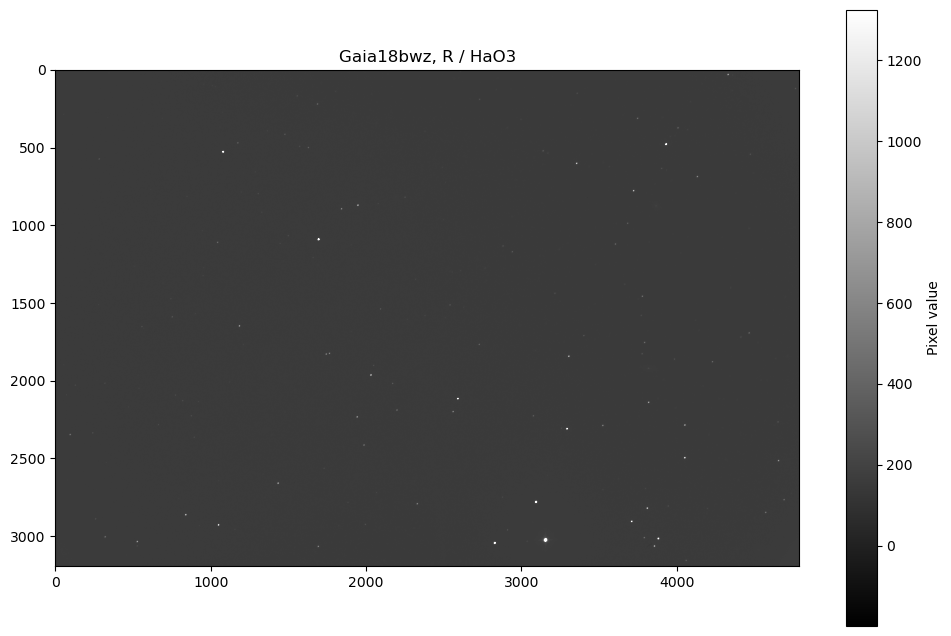

Stacked 10 frames, target Gaia23bsf, filter G / DARK. Total exptime: 1800.0 s, 10 frames


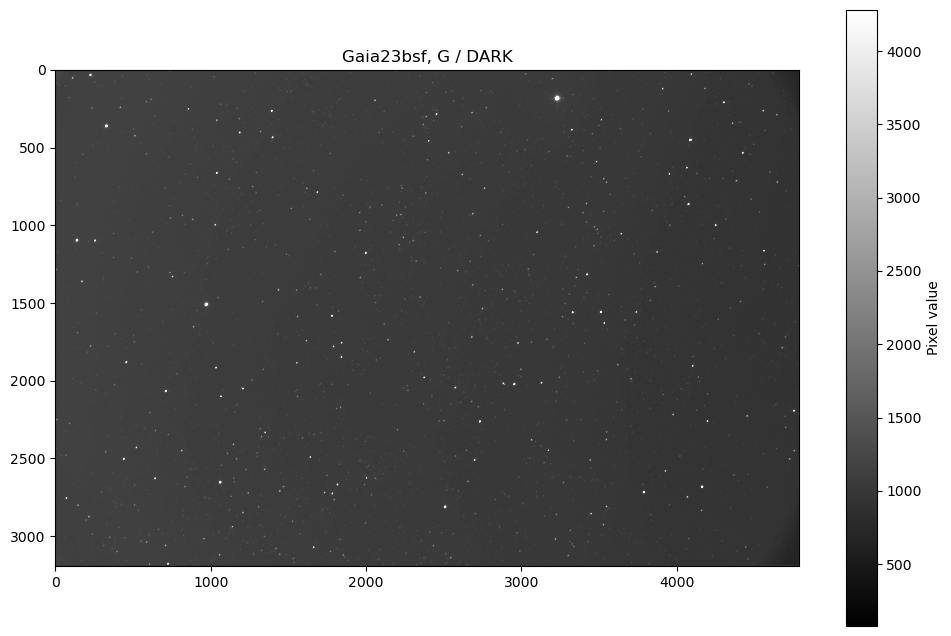

Stacked 10 frames, target Gaia23bsf, filter R / HaO3. Total exptime: 1800.0 s, 10 frames


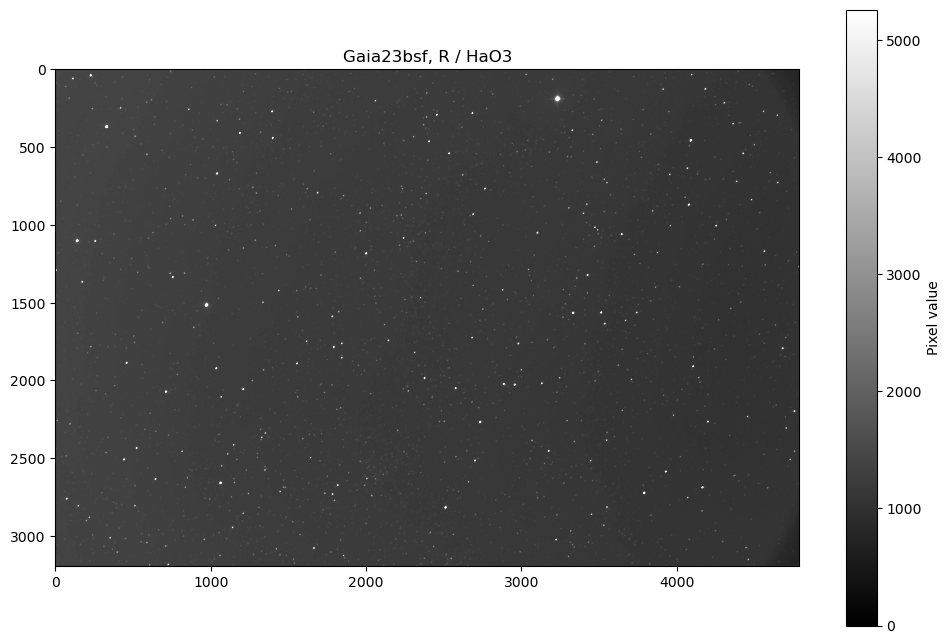

Stacked 12 frames, target Gaia23cnm, filter R / HaO3. Total exptime: 2160.0 s, 12 frames


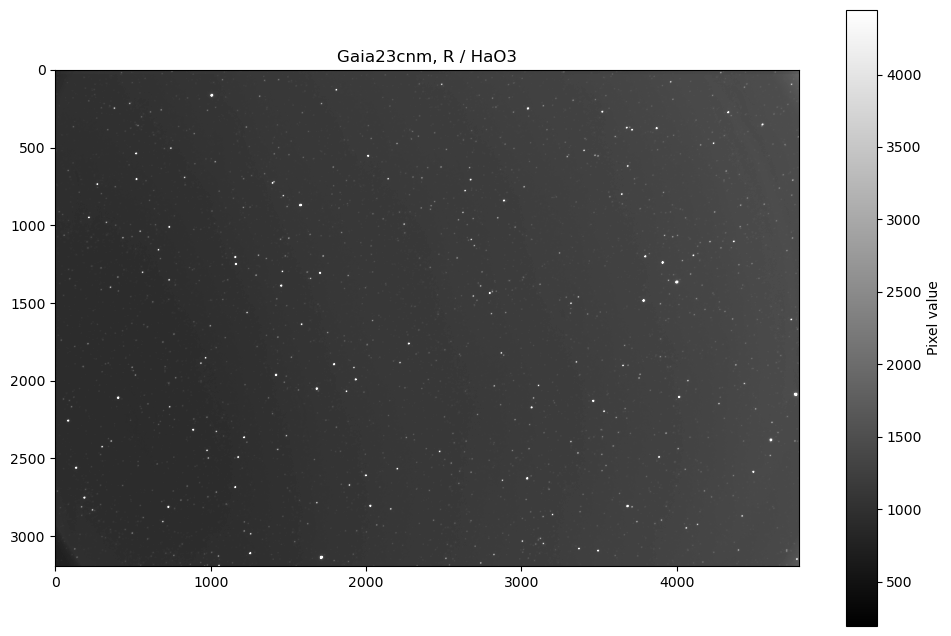

Stacked 7 frames, target Gaia24amo, filter G / DARK. Total exptime: 1260.0 s, 7 frames


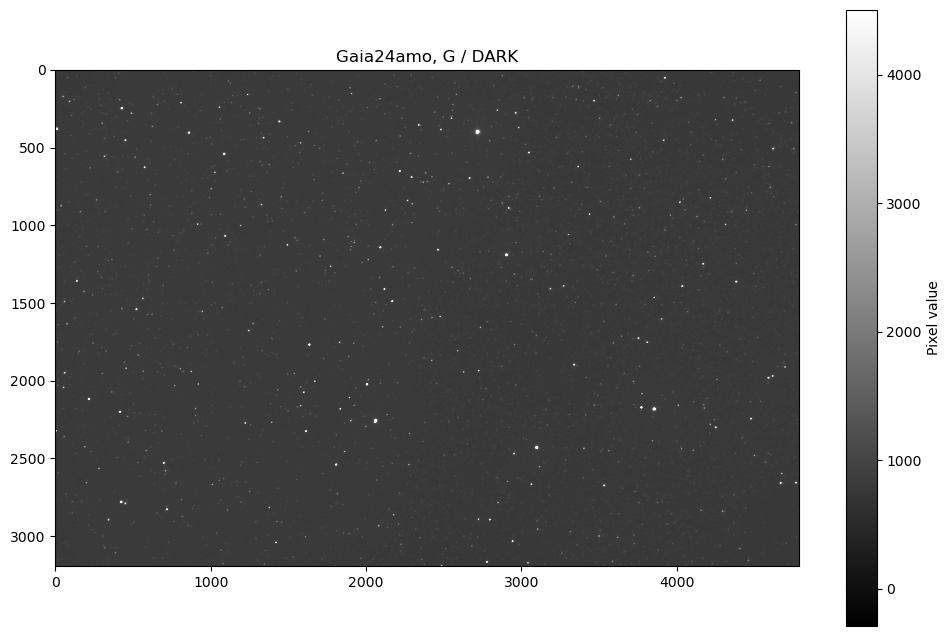

Stacked 9 frames, target Gaia24amo, filter R / HaO3. Total exptime: 1620.0 s, 9 frames


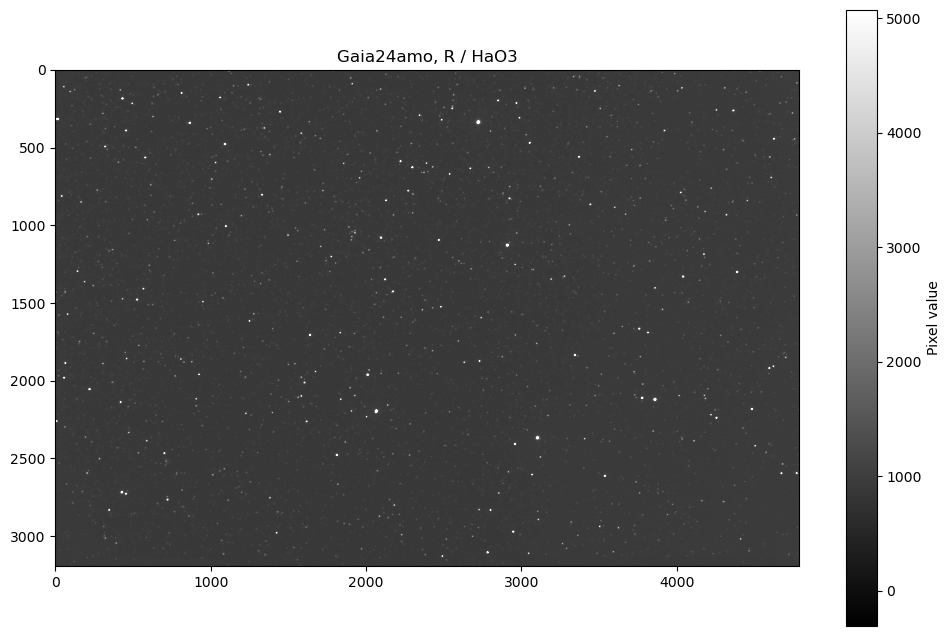

Stacked 2 frames, target SN 2024ggi, filter B. Total exptime: 180.0 s, 2 frames


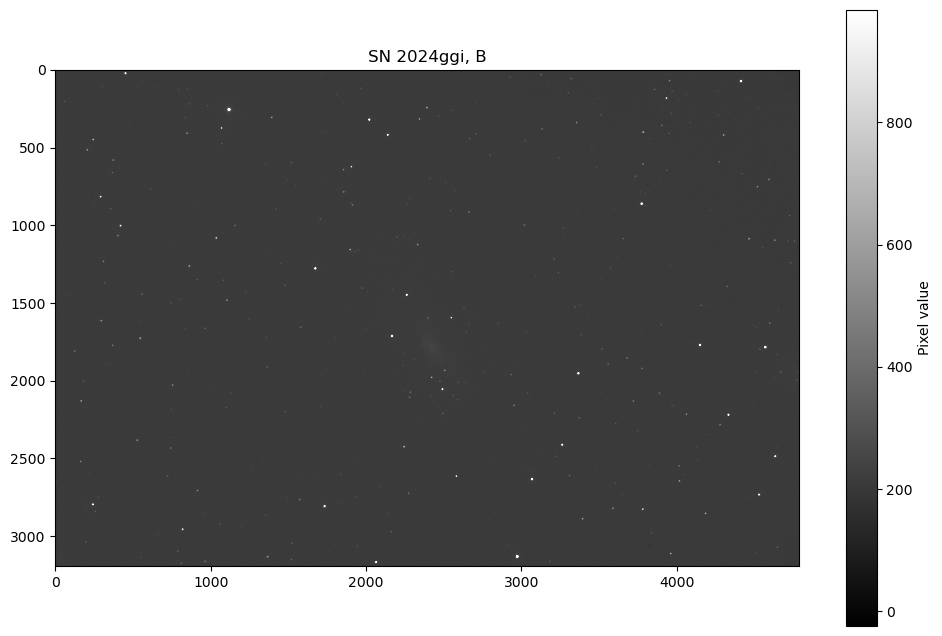

Stacked 2 frames, target SN 2024ggi, filter G / DARK. Total exptime: 180.0 s, 2 frames


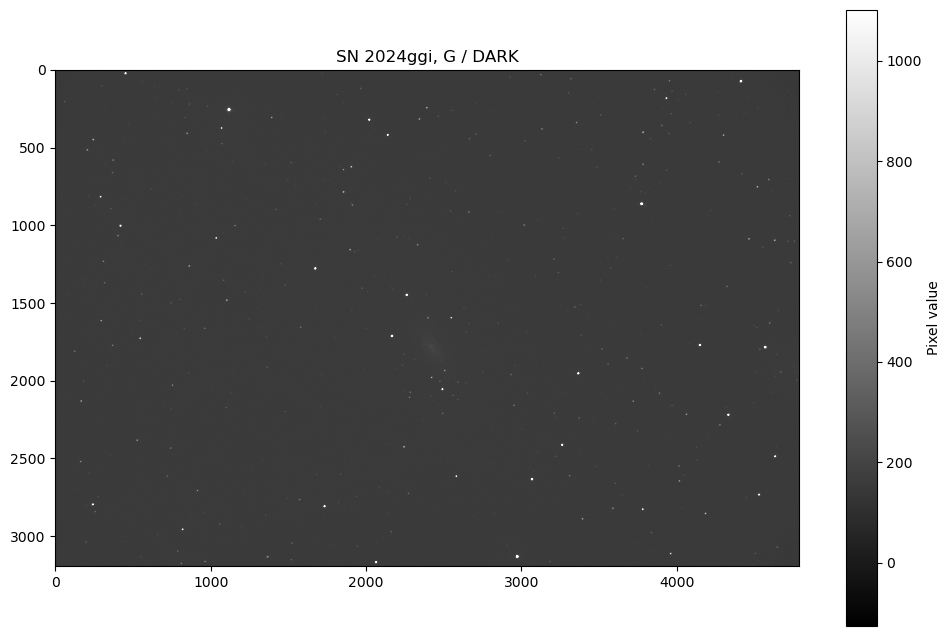

Stacked 2 frames, target SN 2024ggi, filter R / HaO3. Total exptime: 180.0 s, 2 frames


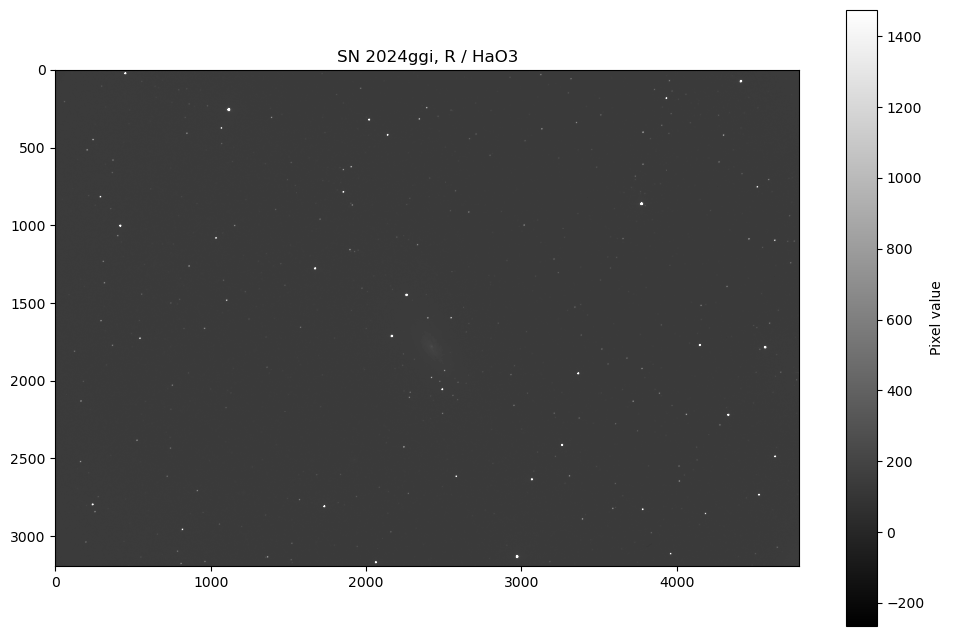

In [26]:
def stack_frames():
    cal_frames = list_fits_files(calibrated_path, None)
    frames_table = Table()
    col1 = Column([], dtype='str', name='path')
    col2 = Column([], dtype='str', name='target')
    col3 = Column([], dtype='str', name='filter')
    frames_table.add_columns([col1, col2, col3])
    
    for fits_path in cal_frames:
        hdr = fits.getheader(fits_path)
        try:
            if hdr['OBJECT'] not in stack_target_names:
                continue
        except TypeError:
            pass
        frames_table.add_row((fits_path, hdr['OBJECT'], hdr['FILTER']))

    if len(frames_table) == 0:
        warnings.warn("No images were stacked.")
        return    
    frames_table = frames_table.group_by(("target", "filter"))
    for stack_set in frames_table.groups:
        frame_datacube = np.empty((len(stack_set), fits_shape[0], fits_shape[1]), dtype=stacked_dtype)
        hdr_set = [fits.getheader(stack_set['path'][0])]
        frame_datacube[0, :, :] = fits.getdata(stack_set['path'][0])
        for i in range(1, len(stack_set)):
            image = fits.getdata(stack_set['path'][i]).byteswap().newbyteorder()  # It is necessary to fix endianness of the image
            aligned_image, _ = aa.register(image, frame_datacube[0, :, :])
            frame_datacube[i, :, :] = aligned_image
            hdr_set.append(fits.getheader(stack_set['path'][i]))
        stacked_frame, _, _ = sigma_clipped_stats(frame_datacube, axis=0)
        
        stacked_hdr = hdr_set[0].copy()
        stacked_hdr.add_history(f"Stacked {len(stack_set)} frames using astroalign, 3 sigma clipped avg")
        stacked_hdr['NFRAMES'] = len(stack_set)
        
        total_exptime = np.sum([hdr['EXPTIME'] for hdr in hdr_set])
        stacked_hdr['EXPTIME'] = total_exptime
        stacked_hdr['EXPOSURE'] = total_exptime
        
        first_frame_idx = np.argmin([hdr['JD'] for hdr in hdr_set])
        last_frame_idx = np.argmax([hdr['JD'] for hdr in hdr_set])
        midpoint_jd = (hdr_set[first_frame_idx]['JD'] + hdr_set[last_frame_idx]['JD'] + hdr_set[last_frame_idx]['EXPTIME'] / 86400.) / 2.  # Assuming exptime in seconds
        effective_start_jd = midpoint_jd - total_exptime / 2. / 86400.  # Start JD which gives the correct midpoint when calculated using exptime
        
        stacked_hdr['DATE-OBS'] = (jd_to_iso(effective_start_jd), "YYYY-MM-DDThh:mm:ss observation start, UT")  # These are all specific to GoChile's Voyager FITS files.
        stacked_hdr['JD'] = (effective_start_jd, "Julian Date at start of exposure")                            # Please readjust header handling for other header contents
        stacked_hdr['JD-HELIO'] = ((hdr_set[first_frame_idx]['JD-HELIO'] 
                                    + hdr_set[last_frame_idx]['JD-HELIO'] 
                                    + hdr_set[last_frame_idx]['EXPTIME'] / 86400.) / 2, "Heliocentric Julian Date at exposure midpoint")
        
        stacked_hdr['BITPIX'] = dtype_to_bitpix[stacked_dtype]
        stacked_hdr.remove('BSCALE', ignore_missing=True)
        stacked_hdr.remove('BZERO', ignore_missing=True)
        stacked_hdr['COMMENT'] = "'DATE-OBS' and 'JD' are effective start times: midpoint - 0.5 exptime"
        
        filename = stacked_hdr['OBJECT'] + '_' + stacked_hdr['FILTER'] + '_stacked_' + stacked_hdr['DATE-OBS'] + fits_extension
        filename = filename.replace("/", "_")
        filename = filename.replace(" ", "")        
        hdu = fits.PrimaryHDU(stacked_frame)
        hdu.header = stacked_hdr
        hdu.writeto(os.path.join(stacked_path, filename), overwrite=True)
        print(f"Stacked {len(stack_set)} frames, target {stacked_hdr['OBJECT']}, filter {stacked_hdr['FILTER']}. Total exptime: {total_exptime} s, {len(stack_set)} frames")
        preview_image(stacked_frame, cmap='gray', sigma_low=3, sigma_high=10, title=f"{stacked_hdr['OBJECT']}, {stacked_hdr['FILTER']}")



if do_image_stacking:
    stack_frames()
    

